### For preparing Udacity exam 1.
changes according wp from NPJ

Notebook 2 is the Notebook supporting K-fold CV

In [1]:
# eventually install EfficientNets
# or other needed packages
!pip install -q efficientnet >> /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# this Notebook is the second to work on my CXR TFREC Dataset
# the dataset contains, in TFREC format, all images taken from NIH CXR dataset
# image have been transformed from initial format (png, 1024x1024)
# to JPEG 256x256 and packed in TFREC files

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import os
import re, math
import time

In [3]:
# to remove some warnings

# TF2 way to reduce logging
# this remove also INFO, verify if needed
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
DEVICE = "TPU" # or "TPU"

# TFRecords file for training/validation
GCS_PATH = KaggleDatasets().get_gcs_path('cxr-tfrec256-may2020')

IMG_SIZES = 256

IMAGE_SIZE = [IMG_SIZES, IMG_SIZES]

# tune it, dependes on Image, size, TPU or GPU
#BATCH_SIZE = 64
BATCH_SIZE = 32

EPOCHS = 50

# for K-fold CV
FOLDS = 5

# WHICH EFFICIENTNET TO USE (B?, B0 from B7)
EFF_NETS = 2

In [5]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE == "GPU":
    n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", n_gpu)
    
    if n_gpu > 1:
        print("Using strategy for multiple GPU")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print('Standard strategy for GPU...')
        strategy = tf.distribute.get_strategy()

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


In [6]:
# changed
ROT_ = 20.0
SHR_ = 2.0
# changed
HZOOM_ = 4.0
WZOOM_ = 4.0
# changed
HSHIFT_ = 4.0
WSHIFT_ = 4.0

# image augmentation
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))

def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [7]:
# not using metadata (only image, for now)
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_idx": tf.io.FixedLenFeature([], tf.string),
        'label' : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    
    # do image augmentation
    image = transform(image, DIM=IMG_SIZES)
    # hearth on the right is not labeled as anomaly, therefore it is ok to flip
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
        
    image_idx = example['image_idx']
    label = example['label']
        
    return image, label 

def read_labeled_tfrecord_for_test(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_idx": tf.io.FixedLenFeature([], tf.string),
        'label' : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    
    # DON't do image augmentation
    label = example['label']
        
    return image, label 

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_idx'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_idx'] if return_image_name else 0

def decode_image(image_data):
    # qua dovrebbe fare la conversione in RGB come richiesto da EfficientNet
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

# count # of images in files.. (embedded in file name)
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [8]:
def load_dataset(filenames, labeled=True, ordered=False, isTest=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    
    if isTest == False:
        dataset = dataset.map(read_labeled_tfrecord)
    else:
        dataset = dataset.map(read_labeled_tfrecord_for_test)
    
    # returns a dataset of (image, labels) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset(filenames):
    dataset = load_dataset(filenames, labeled=True, isTest = False)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_valid_dataset(filenames):
    dataset = load_dataset(filenames, labeled=True, isTest = True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(filenames):
    # for predictions it is crucial the ordering
    dataset = load_dataset(filenames, labeled=True, isTest = True, ordered=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [9]:
# here we define the DNN Model

EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

# as default it used B0

def build_model(dim = IMG_SIZES, ef = 0):
    inp = tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3))
    
    base = EFNS[ef](input_shape=(*IMAGE_SIZE, 3), weights='imagenet', include_top = False)
    
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs = inp,outputs = x)
    
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    
    # removed label smoothing
    fn_loss = tf.keras.losses.BinaryCrossentropy() 
    
    # loss = [focal_loss]
    model.compile(optimizer = opt, loss = [fn_loss], metrics=['AUC', 'accuracy'])
    
    return model

In [10]:
try_model = build_model(dim=IMG_SIZES, ef=EFF_NETS)

try_model.summary()

31940608/31936256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnet-b2 (Model)      (None, 8, 8, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1409      
Total params: 7,769,971
Trainable params: 7,702,403
Non-trainable params: 67,568
_________________________________________________________________


In [11]:
# definisce la variazione temporale del learning rate

def get_lr_callback(batch_size=8):
    lr_start   = 0.00001
    lr_max     = 0.000015 * 10
    # lr_max     = 0.00001 * 20
    lr_min     = 0.00001
    lr_ramp_ep = 20
    # lr_ramp_ep = 20
    lr_sus_ep  = 10
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)
    
    return lr_callback

In [12]:
class LRFinder(tf.keras.callbacks.Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186

    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.grid()
        plt.show()
        
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.grid()
        plt.show()

In [13]:
all_files = tf.io.gfile.glob(GCS_PATH + '/train_valid*.tfrec')
num_total_files = len(all_files)

n_images = count_data_items(all_files)

print('Total number of image for train-validation:', n_images)

Total number of image for train-validation: 10280


In [14]:
def train_one_fold(fold, files_train, files_valid):
    # train_files = list of train_files names
    # valid_files = list of valid files
    
    # constant to customize output
    VERBOSE = 1
    tStart = time.time()
    
    # BUILD MODEL
    if DEVICE=='TPU':
        # to avoid OOM
        tf.tpu.experimental.initialize_tpu_system(tpu)
    
    K.clear_session()
    with strategy.scope():
        print('Building model...')
        model = build_model(dim=IMG_SIZES, ef=EFF_NETS)
    
    # callback to save best model for each fold
    sv = tf.keras.callbacks.ModelCheckpoint('fold-%i.h5'%fold, monitor='val_loss', verbose=1, save_best_only=True,
                                            save_weights_only=True, mode='min', save_freq='epoch')
    
    # TRAIN
    history = model.fit(get_training_dataset(files_train), 
                        epochs=EPOCHS, 
                        callbacks = [sv, get_lr_callback(BATCH_SIZE)], 
                        steps_per_epoch = count_data_items(files_train)/BATCH_SIZE//REPLICAS,
                        validation_data = get_valid_dataset(files_valid), 
                        validation_steps = count_data_items(files_valid)/BATCH_SIZE//REPLICAS,
                        verbose=VERBOSE)
    
    tElapsed = round(time.time() - tStart, 1)
    
    print(' ')
    print('Time (sec) elapsed: ', tElapsed)
    print('...')
    print('...')
    
    return history

In [15]:
# code to manage K-fold CV
SHOW_FILES = True

skf = KFold(n_splits = FOLDS, shuffle = True, random_state=42)

oof_pred = []; oof_tar = []; oof_val = []; oof_names = [] 
# preds = np.zeros((count_data_items(files_test),1))

# for others investigations
# we store all the history
histories = []

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(num_total_files))):
    # display fold info
    print('')
    print('#'*60) 
    print('#### FOLD', fold+1)
    
    print('#### Image Size %i, EfficientNet B%i, batch_size %i'%
          (IMG_SIZES, EFF_NETS, BATCH_SIZE*REPLICAS))
    print('#### Epochs: %i' %(EPOCHS))
    print('#'*60)
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    train_files = tf.io.gfile.glob([GCS_PATH + '/train_valid%.2i*.tfrec'%x for x in idxT])
    valid_files = tf.io.gfile.glob([GCS_PATH + '/train_valid%.2i*.tfrec'%x for x in idxV])
    
    if SHOW_FILES:
        print('Number of training images', count_data_items(train_files))
        print('Number of validation images', count_data_items(valid_files))
    
    # in files h5 fol are numbered starting from 1
    
    # here launch the training for the fold
    history = train_one_fold(fold+1, train_files, valid_files)
    
    histories.append(history)


############################################################
#### FOLD 1
#### Image Size 256, EfficientNet B2, batch_size 256
#### Epochs: 50
############################################################
Number of training images 7280
Number of validation images 3000
Building model...

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
28/28 [==============================] - ETA: 0s - accuracy: 0.5759 - auc: 0.6103 - loss: 0.6777
Epoch 00001: val_loss improved from inf to 0.66311, saving model to fold-1.h5
28/28 [==============================] - 18s 642ms/step - accuracy: 0.5759 - auc: 0.6103 - loss: 0.6777 - val_accuracy: 0.6278 - val_auc: 0.6922 - val_loss: 0.6631 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 1.7e-05.
Epoch 2/50
28/28 [==============================] - ETA: 0s - accuracy: 0.6395 - auc: 0.7006 - loss: 0.6518
Epoch 00002: val_loss improved from 0.66311 to 0.65518, saving model to fold-1.h5
28/28 [==========

28/28 [==============================] - ETA: 0s - accuracy: 0.7913 - auc: 0.8710 - loss: 0.4470
Epoch 00019: val_loss did not improve from 0.36510
28/28 [==============================] - 3s 113ms/step - accuracy: 0.7913 - auc: 0.8710 - loss: 0.4470 - val_accuracy: 0.8409 - val_auc: 0.9273 - val_loss: 0.3858 - lr: 1.3600e-04

Epoch 00020: LearningRateScheduler reducing learning rate to 0.000143.
Epoch 20/50
28/28 [==============================] - ETA: 0s - accuracy: 0.8036 - auc: 0.8811 - loss: 0.4272
Epoch 00020: val_loss improved from 0.36510 to 0.35874, saving model to fold-1.h5
28/28 [==============================] - 5s 184ms/step - accuracy: 0.8036 - auc: 0.8811 - loss: 0.4272 - val_accuracy: 0.8580 - val_auc: 0.9346 - val_loss: 0.3587 - lr: 1.4300e-04

Epoch 00021: LearningRateScheduler reducing learning rate to 0.00015000000000000001.
Epoch 21/50
28/28 [==============================] - ETA: 0s - accuracy: 0.7891 - auc: 0.8655 - loss: 0.4543
Epoch 00021: val_loss improved fro


Epoch 00038: LearningRateScheduler reducing learning rate to 3.936012800000001e-05.
Epoch 38/50
28/28 [==============================] - ETA: 0s - accuracy: 0.8482 - auc: 0.9217 - loss: 0.3524
Epoch 00038: val_loss did not improve from 0.29396
28/28 [==============================] - 3s 115ms/step - accuracy: 0.8482 - auc: 0.9217 - loss: 0.3524 - val_accuracy: 0.8580 - val_auc: 0.9468 - val_loss: 0.3135 - lr: 3.9360e-05

Epoch 00039: LearningRateScheduler reducing learning rate to 3.3488102400000014e-05.
Epoch 39/50
28/28 [==============================] - ETA: 0s - accuracy: 0.8359 - auc: 0.9034 - loss: 0.3842
Epoch 00039: val_loss did not improve from 0.29396
28/28 [==============================] - 3s 121ms/step - accuracy: 0.8359 - auc: 0.9034 - loss: 0.3842 - val_accuracy: 0.8551 - val_auc: 0.9484 - val_loss: 0.3174 - lr: 3.3488e-05

Epoch 00040: LearningRateScheduler reducing learning rate to 2.8790481920000014e-05.
Epoch 40/50
28/28 [==============================] - ETA: 0s - 

35/35 [==============================] - ETA: 0s - accuracy: 0.7357 - auc: 0.8202 - loss: 0.5243
Epoch 00006: val_loss improved from 0.53712 to 0.52138, saving model to fold-2.h5
35/35 [==============================] - 5s 156ms/step - accuracy: 0.7357 - auc: 0.8202 - loss: 0.5243 - val_accuracy: 0.7688 - val_auc: 0.8644 - val_loss: 0.5214 - lr: 4.5000e-05

Epoch 00007: LearningRateScheduler reducing learning rate to 5.2000000000000004e-05.
Epoch 7/50
35/35 [==============================] - ETA: 0s - accuracy: 0.7571 - auc: 0.8370 - loss: 0.5004
Epoch 00007: val_loss improved from 0.52138 to 0.49614, saving model to fold-2.h5
35/35 [==============================] - 6s 159ms/step - accuracy: 0.7571 - auc: 0.8370 - loss: 0.5004 - val_accuracy: 0.7688 - val_auc: 0.8705 - val_loss: 0.4961 - lr: 5.2000e-05

Epoch 00008: LearningRateScheduler reducing learning rate to 5.9000000000000004e-05.
Epoch 8/50
35/35 [==============================] - ETA: 0s - accuracy: 0.7554 - auc: 0.8340 - loss


Epoch 00025: LearningRateScheduler reducing learning rate to 0.00015000000000000001.
Epoch 25/50
35/35 [==============================] - ETA: 0s - accuracy: 0.7902 - auc: 0.8725 - loss: 0.4381
Epoch 00025: val_loss did not improve from 0.33027
35/35 [==============================] - 4s 106ms/step - accuracy: 0.7902 - auc: 0.8725 - loss: 0.4381 - val_accuracy: 0.8313 - val_auc: 0.9317 - val_loss: 0.3697 - lr: 1.5000e-04

Epoch 00026: LearningRateScheduler reducing learning rate to 0.00015000000000000001.
Epoch 26/50
35/35 [==============================] - ETA: 0s - accuracy: 0.8241 - auc: 0.8960 - loss: 0.4019
Epoch 00026: val_loss did not improve from 0.33027
35/35 [==============================] - 4s 101ms/step - accuracy: 0.8241 - auc: 0.8960 - loss: 0.4019 - val_accuracy: 0.8250 - val_auc: 0.9353 - val_loss: 0.3370 - lr: 1.5000e-04

Epoch 00027: LearningRateScheduler reducing learning rate to 0.00015000000000000001.
Epoch 27/50
35/35 [==============================] - ETA: 0s -

35/35 [==============================] - ETA: 0s - accuracy: 0.8554 - auc: 0.9272 - loss: 0.3289
Epoch 00044: val_loss improved from 0.29249 to 0.29079, saving model to fold-2.h5
35/35 [==============================] - 6s 161ms/step - accuracy: 0.8554 - auc: 0.9272 - loss: 0.3289 - val_accuracy: 0.8813 - val_auc: 0.9487 - val_loss: 0.2908 - lr: 1.7697e-05

Epoch 00045: LearningRateScheduler reducing learning rate to 1.6157265115545607e-05.
Epoch 45/50
35/35 [==============================] - ETA: 0s - accuracy: 0.8464 - auc: 0.9243 - loss: 0.3399
Epoch 00045: val_loss improved from 0.29079 to 0.29044, saving model to fold-2.h5
35/35 [==============================] - 5s 155ms/step - accuracy: 0.8464 - auc: 0.9243 - loss: 0.3399 - val_accuracy: 0.8750 - val_auc: 0.9469 - val_loss: 0.2904 - lr: 1.6157e-05

Epoch 00046: LearningRateScheduler reducing learning rate to 1.4925812092436487e-05.
Epoch 46/50
35/35 [==============================] - ETA: 0s - accuracy: 0.8562 - auc: 0.9185 - lo


Epoch 00012: LearningRateScheduler reducing learning rate to 8.7e-05.
Epoch 12/50
32/32 [==============================] - ETA: 0s - accuracy: 0.8193 - auc: 0.8929 - loss: 0.4129
Epoch 00012: val_loss improved from 0.47482 to 0.42671, saving model to fold-3.h5
32/32 [==============================] - 5s 161ms/step - accuracy: 0.8193 - auc: 0.8929 - loss: 0.4129 - val_accuracy: 0.8259 - val_auc: 0.8997 - val_loss: 0.4267 - lr: 8.7000e-05

Epoch 00013: LearningRateScheduler reducing learning rate to 9.400000000000001e-05.
Epoch 13/50
32/32 [==============================] - ETA: 0s - accuracy: 0.7920 - auc: 0.8668 - loss: 0.4543
Epoch 00013: val_loss did not improve from 0.42671
32/32 [==============================] - 3s 108ms/step - accuracy: 0.7920 - auc: 0.8668 - loss: 0.4543 - val_accuracy: 0.7589 - val_auc: 0.8942 - val_loss: 0.5047 - lr: 9.4000e-05

Epoch 00014: LearningRateScheduler reducing learning rate to 0.00010100000000000002.
Epoch 14/50
32/32 [============================


Epoch 00031: LearningRateScheduler reducing learning rate to 0.00015000000000000001.
Epoch 31/50
32/32 [==============================] - ETA: 0s - accuracy: 0.8467 - auc: 0.9079 - loss: 0.3701
Epoch 00031: val_loss did not improve from 0.32566
32/32 [==============================] - 4s 112ms/step - accuracy: 0.8467 - auc: 0.9079 - loss: 0.3701 - val_accuracy: 0.8393 - val_auc: 0.9195 - val_loss: 0.3730 - lr: 1.5000e-04

Epoch 00032: LearningRateScheduler reducing learning rate to 0.00012200000000000001.
Epoch 32/50
32/32 [==============================] - ETA: 0s - accuracy: 0.8428 - auc: 0.9189 - loss: 0.3478
Epoch 00032: val_loss did not improve from 0.32566
32/32 [==============================] - 3s 107ms/step - accuracy: 0.8428 - auc: 0.9189 - loss: 0.3478 - val_accuracy: 0.8616 - val_auc: 0.9290 - val_loss: 0.3535 - lr: 1.2200e-04

Epoch 00033: LearningRateScheduler reducing learning rate to 9.960000000000002e-05.
Epoch 33/50
32/32 [==============================] - ETA: 0s - 

32/32 [==============================] - ETA: 0s - accuracy: 0.8516 - auc: 0.9222 - loss: 0.3453
Epoch 00050: val_loss did not improve from 0.30471
32/32 [==============================] - 4s 113ms/step - accuracy: 0.8516 - auc: 0.9222 - loss: 0.3453 - val_accuracy: 0.8661 - val_auc: 0.9407 - val_loss: 0.3105 - lr: 1.2018e-05
 
Time (sec) elapsed:  355.4
...
...

############################################################
#### FOLD 4
#### Image Size 256, EfficientNet B2, batch_size 256
#### Epochs: 50
############################################################
Number of training images 8280
Number of validation images 2000
Building model...

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
32/32 [==============================] - ETA: 0s - accuracy: 0.5371 - auc: 0.5337 - loss: 0.6928
Epoch 00001: val_loss improved from inf to 0.68285, saving model to fold-4.h5
32/32 [==============================] - 18s 561ms/step - accuracy: 0.5371 - auc: 0.5337 - los

32/32 [==============================] - ETA: 0s - accuracy: 0.7891 - auc: 0.8646 - loss: 0.4524
Epoch 00018: val_loss did not improve from 0.32300
32/32 [==============================] - 3s 106ms/step - accuracy: 0.7891 - auc: 0.8646 - loss: 0.4524 - val_accuracy: 0.8929 - val_auc: 0.9559 - val_loss: 0.3268 - lr: 1.2900e-04

Epoch 00019: LearningRateScheduler reducing learning rate to 0.00013600000000000003.
Epoch 19/50
32/32 [==============================] - ETA: 0s - accuracy: 0.7998 - auc: 0.8715 - loss: 0.4448
Epoch 00019: val_loss did not improve from 0.32300
32/32 [==============================] - 4s 112ms/step - accuracy: 0.7998 - auc: 0.8715 - loss: 0.4448 - val_accuracy: 0.8571 - val_auc: 0.9551 - val_loss: 0.3322 - lr: 1.3600e-04

Epoch 00020: LearningRateScheduler reducing learning rate to 0.000143.
Epoch 20/50
32/32 [==============================] - ETA: 0s - accuracy: 0.7939 - auc: 0.8699 - loss: 0.4453
Epoch 00020: val_loss improved from 0.32300 to 0.29744, saving mo

32/32 [==============================] - ETA: 0s - accuracy: 0.8447 - auc: 0.9103 - loss: 0.3697
Epoch 00037: val_loss did not improve from 0.24592
32/32 [==============================] - 3s 107ms/step - accuracy: 0.8447 - auc: 0.9103 - loss: 0.3697 - val_accuracy: 0.8795 - val_auc: 0.9529 - val_loss: 0.2842 - lr: 4.6700e-05

Epoch 00038: LearningRateScheduler reducing learning rate to 3.936012800000001e-05.
Epoch 38/50
32/32 [==============================] - ETA: 0s - accuracy: 0.8262 - auc: 0.9026 - loss: 0.3788
Epoch 00038: val_loss did not improve from 0.24592
32/32 [==============================] - 4s 113ms/step - accuracy: 0.8262 - auc: 0.9026 - loss: 0.3788 - val_accuracy: 0.8839 - val_auc: 0.9592 - val_loss: 0.2751 - lr: 3.9360e-05

Epoch 00039: LearningRateScheduler reducing learning rate to 3.3488102400000014e-05.
Epoch 39/50
32/32 [==============================] - ETA: 0s - accuracy: 0.8574 - auc: 0.9197 - loss: 0.3435
Epoch 00039: val_loss did not improve from 0.24592
3

32/32 [==============================] - 6s 173ms/step - accuracy: 0.7188 - auc: 0.7935 - loss: 0.5597 - val_accuracy: 0.7411 - val_auc: 0.8265 - val_loss: 0.5520 - lr: 3.8000e-05

Epoch 00006: LearningRateScheduler reducing learning rate to 4.5e-05.
Epoch 6/50
32/32 [==============================] - ETA: 0s - accuracy: 0.7471 - auc: 0.8249 - loss: 0.5226
Epoch 00006: val_loss improved from 0.55199 to 0.49918, saving model to fold-5.h5
32/32 [==============================] - 5s 167ms/step - accuracy: 0.7471 - auc: 0.8249 - loss: 0.5226 - val_accuracy: 0.7679 - val_auc: 0.8572 - val_loss: 0.4992 - lr: 4.5000e-05

Epoch 00007: LearningRateScheduler reducing learning rate to 5.2000000000000004e-05.
Epoch 7/50
32/32 [==============================] - ETA: 0s - accuracy: 0.7529 - auc: 0.8302 - loss: 0.5101
Epoch 00007: val_loss improved from 0.49918 to 0.48333, saving model to fold-5.h5
32/32 [==============================] - 5s 170ms/step - accuracy: 0.7529 - auc: 0.8302 - loss: 0.5101 

32/32 [==============================] - ETA: 0s - accuracy: 0.8135 - auc: 0.8738 - loss: 0.4356
Epoch 00024: val_loss improved from 0.35792 to 0.35125, saving model to fold-5.h5
32/32 [==============================] - 5s 161ms/step - accuracy: 0.8135 - auc: 0.8738 - loss: 0.4356 - val_accuracy: 0.8482 - val_auc: 0.9175 - val_loss: 0.3512 - lr: 1.5000e-04

Epoch 00025: LearningRateScheduler reducing learning rate to 0.00015000000000000001.
Epoch 25/50
32/32 [==============================] - ETA: 0s - accuracy: 0.8262 - auc: 0.9043 - loss: 0.3917
Epoch 00025: val_loss did not improve from 0.35125
32/32 [==============================] - 4s 109ms/step - accuracy: 0.8262 - auc: 0.9043 - loss: 0.3917 - val_accuracy: 0.8438 - val_auc: 0.9112 - val_loss: 0.3787 - lr: 1.5000e-04

Epoch 00026: LearningRateScheduler reducing learning rate to 0.00015000000000000001.
Epoch 26/50
32/32 [==============================] - ETA: 0s - accuracy: 0.7959 - auc: 0.8771 - loss: 0.4314
Epoch 00026: val_los

32/32 [==============================] - ETA: 0s - accuracy: 0.8643 - auc: 0.9345 - loss: 0.3290
Epoch 00043: val_loss did not improve from 0.32118
32/32 [==============================] - 3s 106ms/step - accuracy: 0.8643 - auc: 0.9345 - loss: 0.3290 - val_accuracy: 0.8571 - val_auc: 0.9271 - val_loss: 0.3292 - lr: 1.9621e-05

Epoch 00044: LearningRateScheduler reducing learning rate to 1.769658139443201e-05.
Epoch 44/50
32/32 [==============================] - ETA: 0s - accuracy: 0.8604 - auc: 0.9278 - loss: 0.3315
Epoch 00044: val_loss did not improve from 0.32118
32/32 [==============================] - 3s 107ms/step - accuracy: 0.8604 - auc: 0.9278 - loss: 0.3315 - val_accuracy: 0.8482 - val_auc: 0.9272 - val_loss: 0.3370 - lr: 1.7697e-05

Epoch 00045: LearningRateScheduler reducing learning rate to 1.6157265115545607e-05.
Epoch 45/50
32/32 [==============================] - ETA: 0s - accuracy: 0.8613 - auc: 0.9291 - loss: 0.3309
Epoch 00045: val_loss did not improve from 0.32118
3

In [ ]:
# lr_finder.plot_loss()

In [ ]:
# lr_finder.plot_lr()

In [16]:
def plot_auc(hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['auc'], label='Training auc')
    plt.plot(hist.history['val_auc'], label='Validation auc')
    plt.title('AUC')
    plt.legend(loc='lower right')
    plt.ylabel('AUC')
    plt.xlabel('epoch')
    plt.grid()
    plt.show();

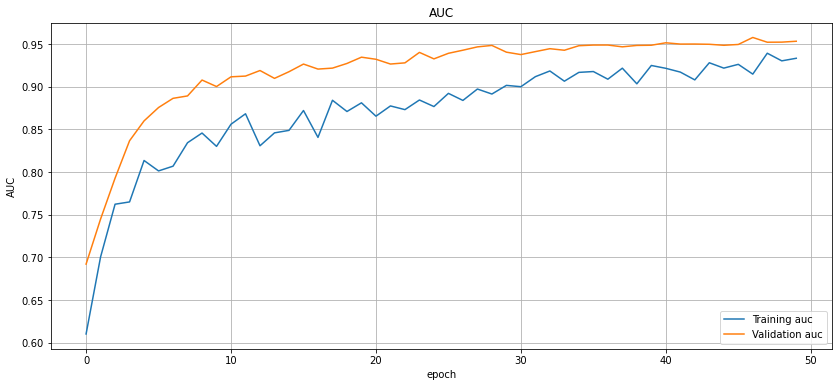

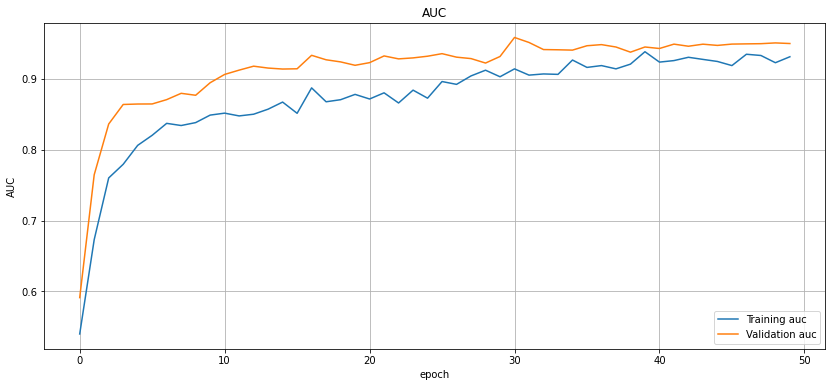

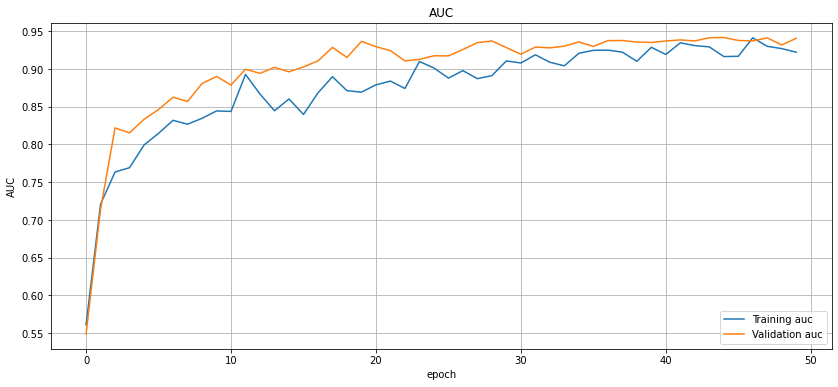

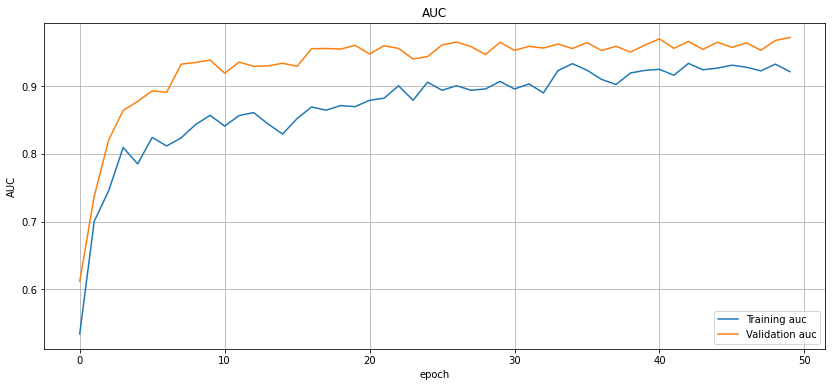

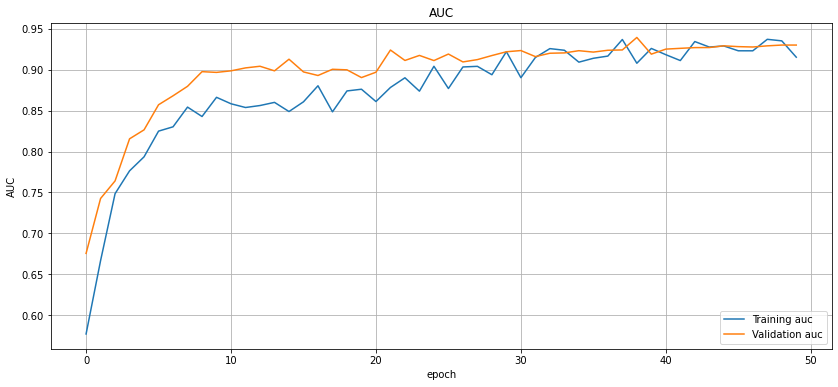

In [17]:
for fold in range(0, FOLDS):
    plot_auc(histories[fold])

In [18]:
def plot_loss(hist):
    plt.figure(figsize=(14,6))
    
    plt.plot(hist.history['loss'], label='Training loss')
    plt.plot(hist.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.legend(loc='lower right')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.show();

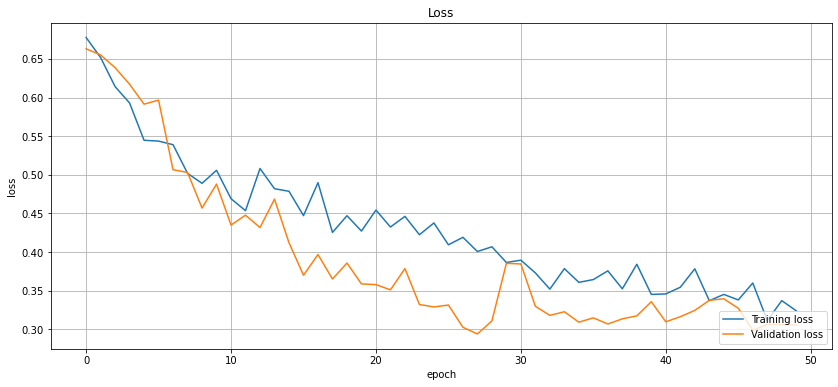

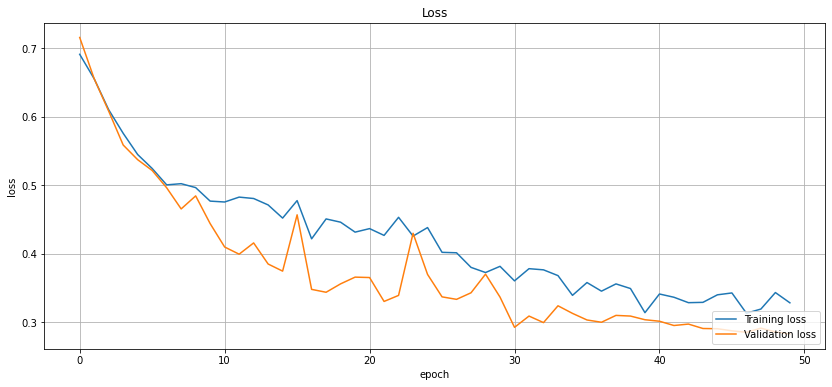

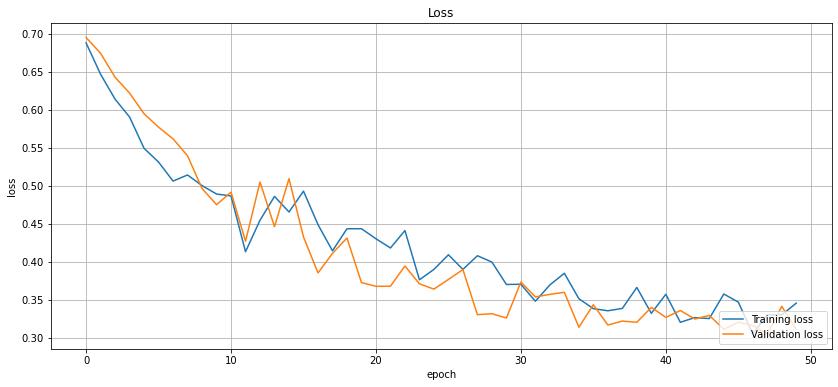

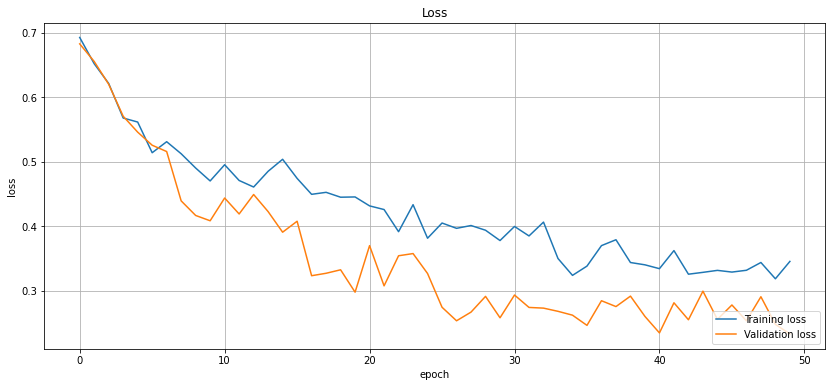

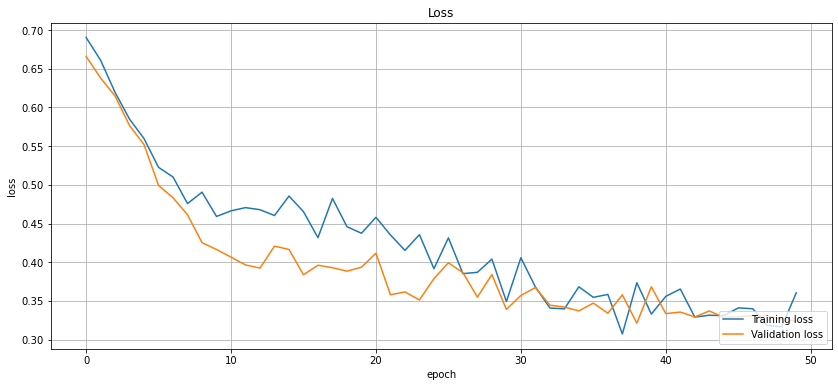

In [19]:
for fold in range(0, FOLDS):
    plot_loss(histories[fold])

In [20]:
# calcolo su test set. Su test set no augmentation

files_test = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

num_total_test_files = len(files_test)

list_auc = []
list_acc = []

for fold in range(1, FOLDS + 1):
    
    model = build_model(dim=IMG_SIZES, ef=EFF_NETS)
    print('Evaluating on fold:', fold)
    
    model.load_weights('fold-%i.h5'%fold)
    
    test_loss, test_auc, test_acc = model.evaluate(get_test_dataset(files_test), verbose = 1, batch_size = BATCH_SIZE,
                                        steps = count_data_items(files_test)/BATCH_SIZE)

    print('Test AUC: ', round(test_auc, 3))
    print('Test ACC: ', round(test_acc, 3))
    print('')
    
    list_auc.append(test_auc)
    list_acc.append(test_acc)

# compute avg, std
np_auc = np.array(list_auc)
np_acc = np.array(list_acc)

avg_auc = np.mean(np_auc)
std_auc = np.std(np_auc)
avg_acc = np.mean(np_acc)
std_acc = np.std(np_acc)

print('AUC: %.3f , std: %.3f' %(avg_auc, std_auc))
print('ACC: %.3f , std: %.3f' %(avg_acc, std_acc))

Evaluating on fold: 1
42/42 [==============================] - 11s 253ms/step - loss: 0.2149 - auc: 0.9832 - accuracy: 0.9174
Test AUC:  0.983
Test ACC:  0.917

Evaluating on fold: 2
42/42 [==============================] - 11s 255ms/step - loss: 0.1791 - auc: 0.9889 - accuracy: 0.9397
Test AUC:  0.989
Test ACC:  0.94

Evaluating on fold: 3
42/42 [==============================] - 11s 261ms/step - loss: 0.1815 - auc: 0.9897 - accuracy: 0.9420
Test AUC:  0.99
Test ACC:  0.942

Evaluating on fold: 4
42/42 [==============================] - 10s 249ms/step - loss: 0.1633 - auc: 0.9881 - accuracy: 0.9509
Test AUC:  0.988
Test ACC:  0.951

Evaluating on fold: 5
42/42 [==============================] - 11s 259ms/step - loss: 0.1782 - auc: 0.9848 - accuracy: 0.9435
Test AUC:  0.985
Test ACC:  0.943

AUC: 0.987 , std: 0.003
ACC: 0.939 , std: 0.011


In [21]:
# all the label from the test dataset
y_true = np.concatenate([y for x, y in get_test_dataset(files_test)], axis=0)

In [22]:
avg_preds = np.zeros((count_data_items(files_test), 1))

for fold in range(1, FOLDS + 1):
    
    model = build_model(dim=IMG_SIZES, ef=EFF_NETS)
    print('Predicting  on fold:', fold)
    
    model.load_weights('fold-%i.h5'%fold)
    preds = model.predict(get_test_dataset(files_test), verbose = True,
                          steps = count_data_items(files_test)/BATCH_SIZE)
    
    avg_preds += preds * 1./FOLDS

Predicting  on fold: 1
42/42 [==============================] - 11s 260ms/step
Predicting  on fold: 2
42/42 [==============================] - 10s 248ms/step
Predicting  on fold: 3
42/42 [==============================] - 11s 252ms/step
Predicting  on fold: 4
42/42 [==============================] - 10s 246ms/step
Predicting  on fold: 5
42/42 [==============================] - 11s 255ms/step


In [23]:
# convert probabilities in labels
THRESHOLD = 0.50

y_pred = np.concatenate([y for y in avg_preds], axis=0)
y_pred = y_pred > THRESHOLD
y_pred = y_pred.astype(int)

acc = accuracy_score(y_true, y_pred)

print('The accuracy on TEST set is:', round(acc, 3))

The accuracy on TEST set is: 0.948


In [24]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print('The Confusion Matrix')
print('TP:', tp)
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)

The Confusion Matrix
TP: 628
TN: 646
FP: 45
FN: 25


In [25]:
SENS = tp/float(fn + tp)
SPEC = tn/float(tn + fp)

print('SENS:', round(SENS, 3))
print('SPEC:', round(SPEC, 3))

SENS: 0.962
SPEC: 0.935


In [26]:
# check accuracy, FP, FN for different thresholds

THRESHOLDS = [0.5, 0.55, 0.6, 0.65, 0.7]

list_acc = []

for THRESHOLD in THRESHOLDS:
    y_pred = np.concatenate([y for y in avg_preds], axis=0)
    y_pred = y_pred > THRESHOLD
    y_pred = y_pred.astype(int)
    acc = accuracy_score(y_true, y_pred)

    print('THR: %f: accuracy on TEST set is: %.3f' %(THRESHOLD, round(acc, 3)))
    list_acc.append(acc)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print('FP:', fp)
    print('FN:', fn)
    SENS = tp/float(fn + tp)
    SPEC = tn/float(tn + fp)

    print('SENS:', round(SENS, 3))
    print('SPEC:', round(SPEC, 3))

THR: 0.500000: accuracy on TEST set is: 0.948
FP: 45
FN: 25
SENS: 0.962
SPEC: 0.935
THR: 0.550000: accuracy on TEST set is: 0.956
FP: 31
FN: 28
SENS: 0.957
SPEC: 0.955
THR: 0.600000: accuracy on TEST set is: 0.961
FP: 22
FN: 31
SENS: 0.953
SPEC: 0.968
THR: 0.650000: accuracy on TEST set is: 0.959
FP: 16
FN: 39
SENS: 0.94
SPEC: 0.977
THR: 0.700000: accuracy on TEST set is: 0.952
FP: 12
FN: 52
SENS: 0.92
SPEC: 0.983
